In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

# %cd /gdrive/My Drive/

Mounted at /content/gdrive


In [9]:
# 導入 PyDrive 和相關程式庫 Import PyDrive and associated libraries.
# 這只需要在筆記本中執行一次 This only needs to be done once in a notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# 驗證並創建 PyDrive 客戶端 Authenticate and create the PyDrive client.
# 這只需要在筆記本中完成一次 This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [10]:
path = '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/'
resources_path = f'{path}Resources/'
videos = os.listdir(path)
all_classes_names = videos
print(videos, all_classes_names)
classes_num = 0
for item in videos:
  if len(item) == 1:
    classes_num += 1
print(range(classes_num))

['a', 'e', 'c', 'd', 'b', 'Resources', 'features.json', 'one_hot_encoded_labels.json', 'labels.json', 'video_files_train.json', 'models', 'output'] ['a', 'e', 'c', 'd', 'b', 'Resources', 'features.json', 'one_hot_encoded_labels.json', 'labels.json', 'video_files_train.json', 'models', 'output']
range(0, 5)


# 新增區段

In [11]:
# Discard the output of this cell.
%%capture

# Install the required libraries.
!pip install pafy youtube-dl moviepy

In [12]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import json
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.pylab as lab

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [13]:
seed_constant = 25
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## Get Video Datas

In [14]:
# Config model detail
cnnlstm_name = 'cnnlstm'
cnnlstm_path = f'{resources_path}/models/{cnnlstm_name}'
cnnlstm_file = os.listdir(cnnlstm_path)

lrcn_name = 'lrcn'
lrcn_path = f'{resources_path}/models/{lrcn_name}'
lrcn_file = os.listdir(lrcn_path)

In [15]:
class Video_process_tool:
  def __init__(self):
    pass
  def get_mask(self, img):
      mask = img[img.shape[0] // 2 - 175: img.shape[0] // 2 + 125,
              img.shape[1] // 2 - 125: img.shape[1] // 2 + 125]
      return mask

  def gray_img(self, img):
      return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

vid = Video_process_tool()

In [16]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 63, 75

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 15

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = path

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["a", "b", "c", "d", "e"]

In [17]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read()

        
        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
        
        frame = cv2.resize(frame,None,fx=0.3,fy=0.3)

        frame = vid.get_mask(frame)
        # print(frame.shape)
        # frame = vid.gray_img(frame) 

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [18]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}, Total File Num: {len(files_list)}')
        
        # Iterate through all the files present in the files list.
        for num, file_name in enumerate(files_list):
            
            print(f'Processing {num+1} Data')
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)
print(one_hot_encoded_labels)

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test, video_files_train, video_files_test = train_test_split(features, one_hot_encoded_labels, video_files_paths, random_state = seed_constant, train_size=0.8)

NameError: ignored

In [ ]:

with open(f'{resources_path}/features.json', 'w') as f:
  json.dump(features.tolist(), f)
with open(f'{resources_path}/one_hot_encoded_labels.json', 'w') as f:
  json.dump(one_hot_encoded_labels.tolist(), f)
with open(f'{resources_path}/labels.json', 'w') as f:
  json.dump(labels.tolist(), f)
with open(f'{resources_path}/video_files_train.json', 'w') as f:
  json.dump(video_files_train, f)
with open(f'{resources_path}/video_files_test.json', 'w') as f:
  json.dump(video_files_test, f)


# Load Train Datas

In [19]:
with open(f'{resources_path}/features.json', 'r') as f:
  features = np.array(json.load(f))
with open(f'{resources_path}/one_hot_encoded_labels.json', 'r') as f:
  one_hot_encoded_labels = np.array(json.load(f))
with open(f'{resources_path}/labels.json', 'r') as f:
  labels = np.array(json.load(f))
with open(f'{resources_path}/video_files_train.json', 'r') as f:
  video_files_train = json.load(f)
with open(f'{resources_path}/video_files_test.json', 'r') as f:
  video_files_test = json.load(f)

# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, random_state = seed_constant, train_size=0.8)

# Training

In [20]:
modelPath = f'{path}/models'
if not os.path.exists(modelPath):
  os.mkdir(modelPath)

In [ ]:
print(video_files_test)

['/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/e/a-z (24)_4.mp4', '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/d/a-z (24)_2.mp4', '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/b/b (7).mp4', '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/e/a-z (24)_17.mp4', '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/d/a-z (24)_16.mp4', '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/a/a (7).mp4', '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/d/a-z (24)_4.mp4', '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/e/a-z (24)_8.mp4', '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/d/a-z (24)_19.mp4', '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/c/c (2).mp4', '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/a/a (1).mp4', '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/d/a-z (24)_10.mp4', '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/c/c (8).mp4', '/content/gdrive/My

In [ ]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (5, 5), activation = 'relu',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                         IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    # model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'relu', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3), activation = 'relu', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    # model.add(TimeDistributed(Dropout(0.2)))
    
    # model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3), activation = 'relu', data_format = "channels_last",
    #                      recurrent_dropout=0.2, return_sequences=True))
    
    # model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [ ]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 15, 71, 59, 8)     8832      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 36, 30, 8)    0         
 )                                                               
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 15, 34, 28, 16)    13888     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 15, 17, 14, 16)   0         
 3D)                                                             
                                                                 
 time_distributed (TimeDistr  (None, 15, 17, 14, 16)   0         
 ibuted)                                                         
                                                        

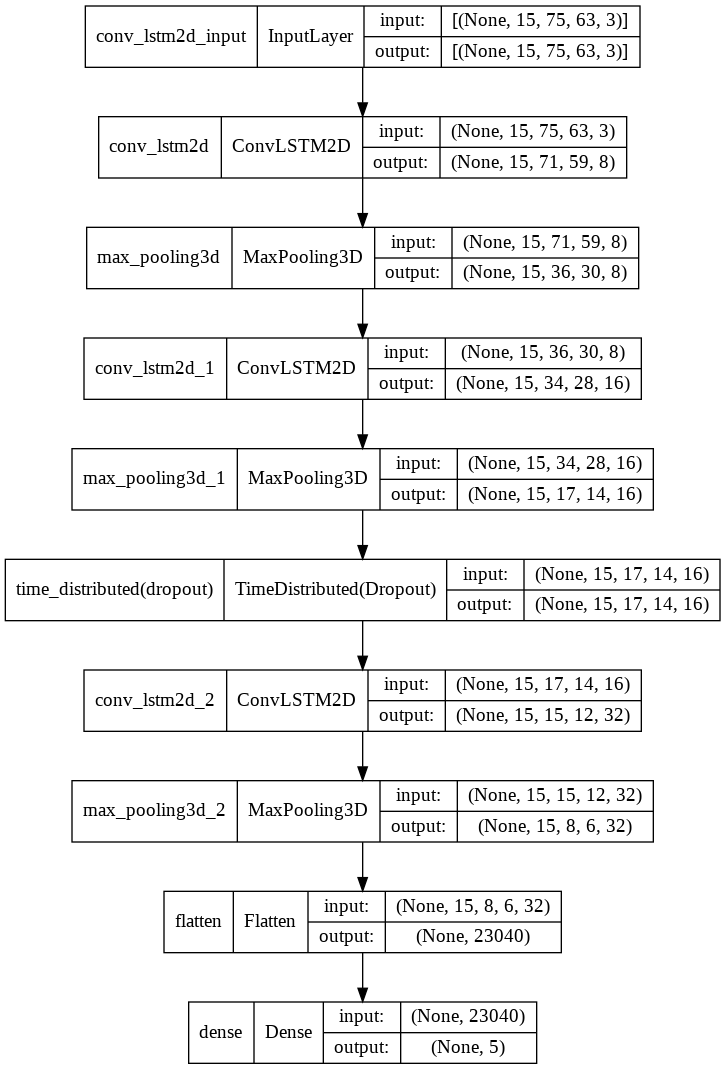

In [ ]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = f'{modelPath}/convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 8,
                            shuffle = True, validation_split = 0.2,
                            callbacks = [early_stopping_callback])

Epoch 1/50
8/8 [==============================] - 15s 785ms/step - loss: 0.2631 - accuracy: 0.8852 - val_loss: 1.7117 - val_accuracy: 0.7500
Epoch 2/50
8/8 [==============================] - 5s 591ms/step - loss: 0.2793 - accuracy: 0.8525 - val_loss: 1.5799 - val_accuracy: 0.7500
Epoch 3/50
8/8 [==============================] - 5s 565ms/step - loss: 0.1630 - accuracy: 0.9344 - val_loss: 1.4939 - val_accuracy: 0.6250
Epoch 4/50
8/8 [==============================] - 5s 587ms/step - loss: 0.2363 - accuracy: 0.9016 - val_loss: 1.6550 - val_accuracy: 0.6250
Epoch 5/50
8/8 [==============================] - 5s 580ms/step - loss: 0.1359 - accuracy: 0.9672 - val_loss: 2.0761 - val_accuracy: 0.6875
Epoch 6/50
8/8 [==============================] - 5s 619ms/step - loss: 0.1405 - accuracy: 0.9508 - val_loss: 2.6028 - val_accuracy: 0.6875
Epoch 7/50
8/8 [==============================] - 5s 605ms/step - loss: 0.0777 - accuracy: 0.9672 - val_loss: 1.5539 - val_accuracy: 0.7500
Epoch 8/50
8/8 [===

In [ ]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

1/1 [==============================] - 1s 1s/step - loss: 0.4941 - accuracy: 0.7500


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
model_name = 'convlstm'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'{modelPath}/models/{model_name}/convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}3.h5'

# Save your Model.
convlstm_model.save(model_file_name)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

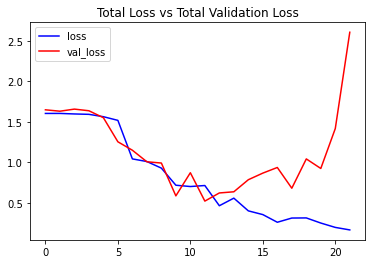

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

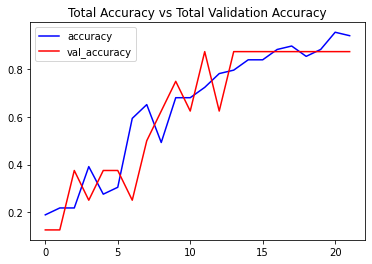

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

# LRCN Model

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(8, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    # model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    # model.add(TimeDistributed(Dropout(0.25)))
    
    # model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    # model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_30 (TimeDi  (None, 15, 75, 63, 8)    224       
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 15, 18, 15, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 15, 18, 15, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 15, 18, 15, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 15, 4, 3, 16)    

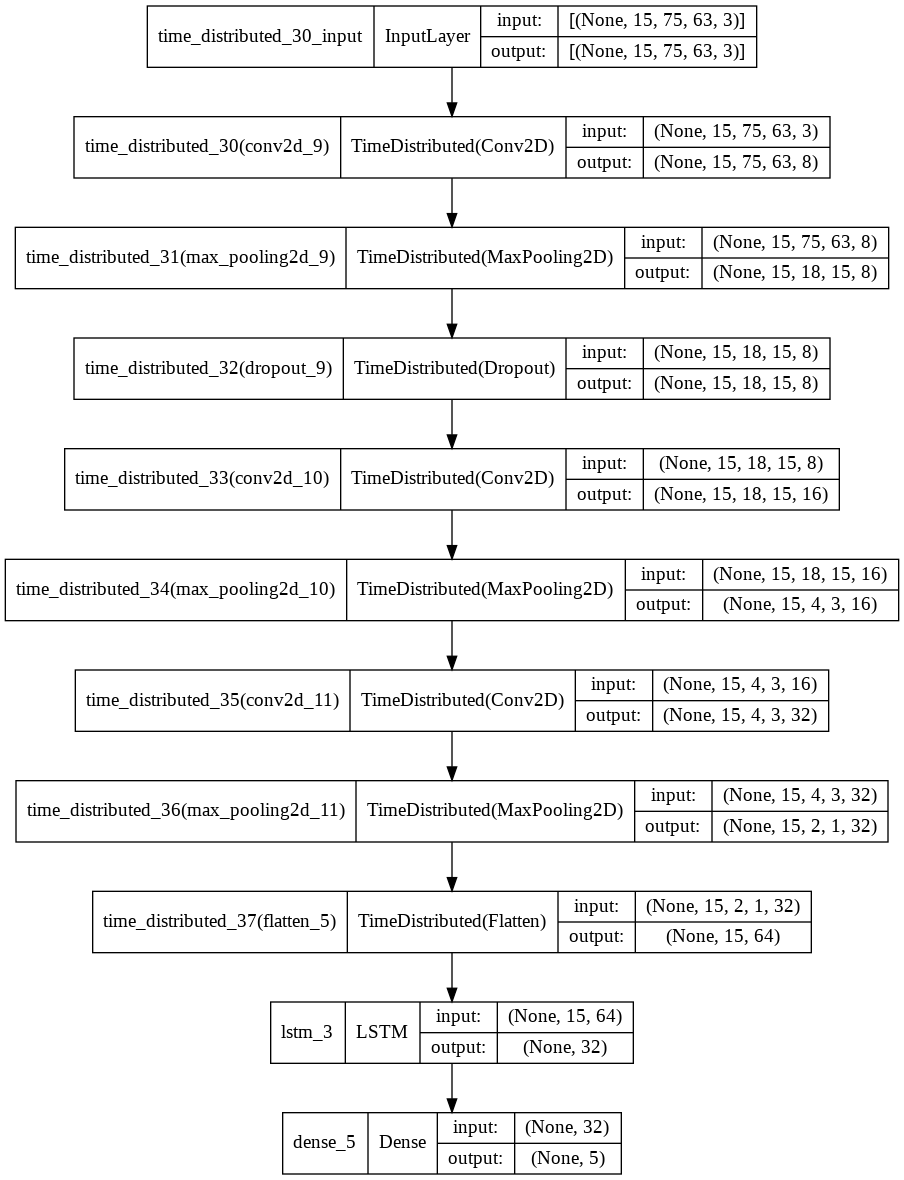

In [ ]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 140, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/140
8/8 [==============================] - 3s 125ms/step - loss: 0.4279 - accuracy: 0.7869 - val_loss: 0.4945 - val_accuracy: 0.8125
Epoch 2/140
8/8 [==============================] - 0s 28ms/step - loss: 0.3442 - accuracy: 0.8525 - val_loss: 0.5712 - val_accuracy: 0.6250
Epoch 3/140
8/8 [==============================] - 0s 28ms/step - loss: 0.4565 - accuracy: 0.7705 - val_loss: 0.5709 - val_accuracy: 0.7500
Epoch 4/140
8/8 [==============================] - 0s 34ms/step - loss: 0.3077 - accuracy: 0.9344 - val_loss: 0.5284 - val_accuracy: 0.9375
Epoch 5/140
8/8 [==============================] - 0s 35ms/step - loss: 0.3913 - accuracy: 0.7869 - val_loss: 0.5284 - val_accuracy: 0.8125
Epoch 6/140
8/8 [==============================] - 0s 30ms/step - loss: 0.3171 - accuracy: 0.8852 - val_loss: 0.4944 - val_accuracy: 0.7500
Epoch 7/140
8/8 [==============================] - 0s 28ms/step - loss: 0.2914 - accuracy: 0.8361 - val_loss: 0.5083 - val_accuracy: 0.8750
Epoch 8/140
8/8 [==

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

1/1 [==============================] - 9s 9s/step - loss: 0.2569 - accuracy: 0.8500


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'{path}/models/lrcn/LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}3.h5'

# Save the Model.
LRCN_model.save(model_file_name)

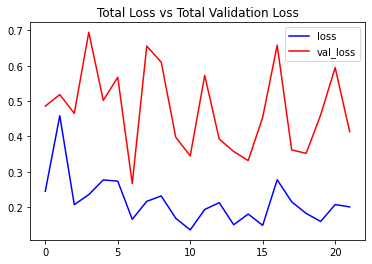

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

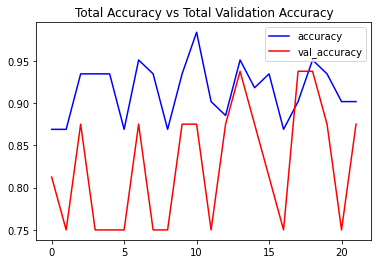

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# Prediction


### Load Model

In [21]:
cnnlstm = tf.keras.models.load_model(f'{cnnlstm_path}/{cnnlstm_file[0]}')
LRCN_model = tf.keras.models.load_model(f'{lrcn_path}/{lrcn_file[0]}')

In [22]:
accuarcy_array = []
predict_array = []
predictor = LRCN_model

In [23]:
def predict_on_video(predictor, video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        frame = cv2.resize(frame,None,fx=0.3,fy=0.3)

        frame = vid.get_mask(frame)

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = predictor.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

            # print(f'Predicted id: {predicted_label}, labels: {predicted_class_name}')
        # Write predicted class name on top of the frame.
        
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        # Write The frame into the disk using the VideoWriter Object.
        # video_writer.write(frame)
    print('Name:', predicted_class_name)
    predict_array.append(predicted_class_name)
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [24]:
all_files = video_files_test

In [25]:
print(video_files_test)

['/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/e/a-z (24)_4.mp4', '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/d/a-z (24)_2.mp4', '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/b/b (7).mp4', '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/e/a-z (24)_17.mp4', '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/d/a-z (24)_16.mp4', '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/a/a (7).mp4', '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/d/a-z (24)_4.mp4', '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/e/a-z (24)_8.mp4', '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/d/a-z (24)_19.mp4', '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/c/c (2).mp4', '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/a/a (1).mp4', '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/d/a-z (24)_10.mp4', '/content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/c/c (8).mp4', '/content/gdrive/My

In [ ]:

def list_all_files():
  global all_files
  all_files = []
  for i in range(len(CLASSES_LIST)):
    class_type = CLASSES_LIST[i]
    video_path = f'{video_files_test}{class_type}'
    path_videos = os.listdir(video_path)
    for v in path_videos:
      all_files.append(f'{path}{class_type}/{v}')

  random.shuffle(all_files)
  print(all_files)

In [26]:
def testModel(TestTime):
  # Construct the output video path.
  
  global accuarcy_array, predict_array, all_files
  accuarcy_array = []
  predict_array = []
  # list_all_files()
  TestTime = min(TestTime, len(all_files))
  for times in range(TestTime):
    input_video_file_path = random.choice(all_files)
    all_files.remove(input_video_file_path)
    class_type = input_video_file_path[len(path)]
    print(f'Predicting{times + 1}: {input_video_file_path}', end=', ')
    if not os.path.exists(f'{path}/output'):
      os.mkdir(f'{path}/output')

    output_video_file_path = f'{path}/output/test.mp4'

    # Perform Action Recognition on the Test Video.
    
    predict_on_video(LRCN_model, input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
    accuarcy_array.append(class_type)

    # Display the output video.
    # VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

  accuracy = 0
  # print(len(accuarcy_array), len(predict_array))
  for i in range(len(accuarcy_array)):
    try:
      accuracy += int(accuarcy_array[i] == predict_array[i])
    except:
      print('Length:', len(accuarcy_array), len(predict_array))
  accuracy = (accuracy) / len(accuarcy_array)
  print(accuracy)

In [27]:
testModel(500)

Predicting1: /content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/c/c (8).mp4, Name: c
Predicting2: /content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/e/a-z (24)_4.mp4, Name: d
Predicting3: /content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/e/a-z (24)_8.mp4, Name: e
Predicting4: /content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/d/a-z (24)_10.mp4, Name: e
Predicting5: /content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/c/c (18).mp4, Name: c
Predicting6: /content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/d/a-z (24)_2.mp4, Name: d
Predicting7: /content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/b/b (11).mp4, Name: a
Predicting8: /content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/d/a-z (24)_3.mp4, Name: d
Predicting9: /content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/d/a-z (24)_4.mp4, Name: d
Predicting10: /content/gdrive/MyDrive/laserRecognition/字母辨識/1sec_video/b/b (7).mp4, Name: b
Predicting11: /content/gdrive/MyDrive/laserRecognition/字

In [29]:
print(accuarcy_array)
print(predict_array)

['c', 'e', 'e', 'd', 'c', 'd', 'b', 'd', 'd', 'b', 'c', 'e', 'd', 'c', 'e', 'e', 'd', 'e', 'a', 'a']
['c', 'd', 'e', 'e', 'c', 'd', 'a', 'd', 'd', 'b', 'c', 'e', 'd', 'c', 'e', 'e', 'd', 'e', 'a', 'a']


In [ ]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []
    
    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read() 

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255
        
        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    # Release the VideoCapture object. 
    video_reader.release()

In [ ]:
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()